# Simulation Benchmarks for FMI.jl
by Tobias Thummerer

Last update: 07.11.2023

🚧 This benchmark is under development, so do not give too much weight to the current results. 🚧

The purpose of this benchmark is to keep track of changes, that influence the simulation performance over different releases. Idealy, simulation time and memory usage should decrease with every new release, but new features and corrections could lead to slightly decreased performances.

Simulation of a vehicle longitudinal dynamics model with six states and time events triggered with 100 Hz. Additional state events, but less than time events. See solver log for details.

## License

In [1]:
# Copyright (c) 2023 Tobias Thummerer, Lars Mikelsons
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMI.jl/blob/main/LICENSE) file in the project root for details.

In [2]:
# we use distributed to check out different FMI.jl versions over different processes
using Distributed 
using Plots
 
# versions to check
versions = ("0.11.0", "0.12.0", "0.13.0", "PATHC:\\Users\\thummeto\\Documents\\FMI.jl")
numVersions = length(versions)

# one worker per version
workers = addprocs(numVersions);

In [3]:
# include benchmarking code
include(joinpath(@__DIR__, "benchmark_helper.jl"));

In [4]:
# install a specific version of FMI.jl on every worker process 
@suppress begin
    futures = Vector{Any}(undef, numVersions);
    for i in 1:numVersions
        futures[i] = @spawnat workers[i] setupVersion(versions[i]);
    end
    fetch.(futures);
end

4-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing

In [5]:
@everywhere workers using FMI, FMIZoo
@everywhere workers data = FMIZoo.VLDM(:train)
@everywhere workers fmu = fmiLoad("VLDM", "Dymola", "2020x"; type=:ME)
@everywhere workers using FMI.DifferentialEquations: Tsit5, Rosenbrock23

@everywhere workers realBuffer = zeros(fmi2Real, 2)
@everywhere workers realVRs = vcat(fmu.modelDescription.stateValueReferences, fmu.modelDescription.derivativeValueReferences)

@everywhere workers x0=zeros(fmi2Real, 6)
@everywhere workers grad = (p, x0, fmu, data, solver) -> ReverseDiff.gradient((_p) -> loss(_p, x0, fmu, data, solver), p)

┌ Warning: Replacing docs for `FMI.DEPRECATED :: Union{}` in module `FMI`
└ @ Base.Docs docs\Docs.jl:243


      From worker 2:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 2:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.Pk

      From worker 2:	┌ Error: Error during loading of extension SpecialFunctionsChainRulesCoreExt of SpecialFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:


      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1290
      From worker 2:	│      [6] run_package_callbacks(modkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1124
      From worker 2:	│      [7] _tryrequire_from_serialized(m

      From worker 2:	WARNING: Method definition fmi3SetDebugLogging(FMICore.FMU3Instance{F} where F) in module FMIImport at C:\Users\thummeto\.julia\packages\FMIImport\MhCuf\src\FMI3\int.jl:47 overwritten at C:\Users\thummeto\.julia\packages\FMIImport\MhCuf\src\FMI3\int.jl:17.
      From worker 2:	  ** incremental compilation may be fatally broken for this module **
      From worker 2:	
      From worker 2:	WARNING: Method definition fmi3GetContinuousStateDerivatives!(FMICore.FMU3Instance{F} where F, AbstractArray{Float64, N} where N) in module FMIImport at C:\Users\thummeto\.julia\packages\FMIImport\MhCuf\src\FMI3\int.jl:2601 overwritten at C:\Users\thummeto\.julia\packages\FMIImport\MhCuf\src\FMI3\int.jl:2566.
      From worker 2:	  ** incremental compilation may be fatally broken for this module **
      From worker 2:	


      From worker 3:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 3:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1793


      From worker 3:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 3:	│   exception =
      From worker 3:	│    1-element ExceptionStack:
      From worker 3:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 3:	│    Stacktrace:
      From worker 3:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1797
      From worker 3:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1660
      From worker 3:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 3:	│        @ Base .\loading.jl:1658
      From worker 3:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 3:	│        @ Base .\loading.jl:1255
      From worker 3:	│      [5] run_extension_callbacks(pkgid::Base.Pk


      From worker 3:	│     [16] top-level scope
      From worker 3:	│        @ stdin:3
      From worker 3:	│     [17] eval
      From worker 3:	│        @ .\boot.jl:370 [inlined]
      From worker 3:	│     [18] include_string(mapexpr::typeof(identity), mod::Module, code::String, filename::String)
      From worker 3:	│        @ Base .\loading.jl:1903
      From worker 3:	│     [19] include_string
      From worker 3:	│        @ .\loading.jl:1913 [inlined]
      From worker 3:	│     [20] exec_options(opts::Base.JLOptions)
      From worker 3:	│        @ Base .\client.jl:305
      From worker 3:	│     [21] _start()
      From worker 3:	│        @ Base .\client.jl:522
      From worker 3:	└ @ Base loading.jl:1261
      From worker 3:	┌ Warning: Module SpecialFunctionsChainRulesCoreExt with build ID fafbfcfd-c035-fd4c-0001-752e89321671 is missing from the cache.
      From worker 3:	│ This may mean SpecialFunctionsChainRulesCoreExt [9eb7bdd4-e44c-55fc-b9cc-1a32cb715188] does not support

      From worker 2:	ERROR: LoadError: SystemError: opening file "C:\\Users\\thummeto\\.julia\\compiled\\v1.9\\DiffEqCallbacks\\TKs5l_QE6Er_3.ji": No such file or directory
      From worker 2:	Stacktrace:
      From worker 2:	  [1] systemerror(p::String, errno::Int32; extrainfo::Nothing)
      From worker 2:	    @ Base .\error.jl:176
      From worker 2:	  [2] #systemerror#82
      From worker 2:	    @ .\error.jl:175 [inlined]
      From worker 2:	  [3] systemerror
      From worker 2:	    @ .\error.jl:175 [inlined]
      From worker 2:	  [4] open(fname::String; lock::Bool, read::Bool, write::Nothing, create::Nothing, truncate::Nothing, append::Nothing)
      From worker 2:	    @ Base .\iostream.jl:293
      From worker 2:	  [5] open
      From worker 2:	    @ .\iostream.jl:275 [inlined]
      From worker 2:	  [6] open(fname::String, mode::String; lock::Bool)
      From worker 2:	    @ Base .\iostream.jl:356
      From worker 2:	  [7] open
      From worker 2:	    @ .\iostream.jl:355 

      From worker 2:	 [17] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::String)
      From worker 2:	    @ Base .\loading.jl:2049
      From worker 2:	 [18] top-level scope
      From worker 2:	    @ stdin:3
      From worker 2:	in expression starting at C:\Users\thummeto\.julia\packages\SteadyStateDiffEq\YRBU4\src\SteadyStateDiffEq.jl:1
      From worker 2:	in expression starting at stdin:3


      From worker 2:	ERROR: LoadError: Failed to precompile SteadyStateDiffEq [9672c7b4-1e72-59bd-8a11-6ac3964bc41f] to "C:\\Users\\thummeto\\.julia\\compiled\\v1.9\\SteadyStateDiffEq\\jl_B3CA.tmp".
      From worker 2:	Stacktrace:
      From worker 2:	  [1] error(s::String)
      From worker 2:	    @ Base .\error.jl:35
      From worker 2:	  [2] compilecache(pkg::Base.PkgId, path::String, internal_stderr::IO, internal_stdout::IO, keep_loaded_modules::Bool)
      From worker 2:	    @ Base .\loading.jl:2300
      From worker 2:	  [3] compilecache
      From worker 2:	    @ .\loading.jl:2167 [inlined]
      From worker 2:	  [4] _require(pkg::Base.PkgId, env::String)
      From worker 2:	    @ Base .\loading.jl:1805
      From worker 2:	  [5] _require_prelocked(uuidkey::Base.PkgId, env::String)
      From worker 2:	    @ Base .\loading.jl:1660
      From worker 2:	  [6] macro expansion
      From worker 2:	    @ .\loading.jl:1648 [inlined]
      From worker 2:	  [7] macro expansion
      

      From worker 2:	    @ .\Base.jl:457 [inlined]
      From worker 2:	 [10] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::String)
      From worker 2:	    @ Base .\loading.jl:2049
      From worker 2:	 [11] top-level scope
      From worker 2:	    @ stdin:3
      From worker 2:	in expression starting at C:\Users\thummeto\.julia\packages\DifferentialEquations\nHZ7l\src\DifferentialEquations.jl:1
      From worker 2:	in expression starting at stdin:3


      From worker 2:	ERROR: LoadError: Failed to precompile DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa] to "C:\\Users\\thummeto\\.julia\\compiled\\v1.9\\DifferentialEquations\\jl_98D0.tmp".
      From worker 2:	Stacktrace:
      From worker 2:	  [1] error(s::String)
      From worker 2:	    @ Base .\error.jl:35
      From worker 2:	  [2] compilecache(pkg::Base.PkgId, path::String, internal_stderr::IO, internal_stdout::IO, keep_loaded_modules::Bool)
      From worker 2:	    @ Base .\loading.jl:2300
      From worker 2:	  [3] compilecache
      From worker 2:	    @ .\loading.jl:2167 [inlined]
      From worker 2:	  [4] _require(pkg::Base.PkgId, env::String)
      From worker 2:	    @ Base .\loading.jl:1805
      From worker 2:	  [5] _require_prelocked(uuidkey::Base.PkgId, env::String)


      From worker 2:	    @ Base .\loading.jl:1660
      From worker 2:	  [6] macro expansion
      From worker 2:	    @ .\loading.jl:1648 [inlined]
      From worker 2:	  [7] macro expansion
      From worker 2:	    @ .\lock.jl:267 [inlined]
      From worker 2:	  [8] require(into::Module, mod::Symbol)
      From worker 2:	    @ Base .\loading.jl:1611
      From worker 2:	  [9] include(mod::Module, _path::String)
      From worker 2:	    @ Base .\Base.jl:457
      From worker 2:	 [10] include(x::String)
      From worker 2:	    @ FMI C:\Users\thummeto\.julia\packages\FMI\Dr3da\src\FMI.jl:6
      From worker 2:	 [11] top-level scope
      From worker 2:	    @ C:\Users\thummeto\.julia\packages\FMI\Dr3da\src\FMI.jl:70
      From worker 2:	 [12] include
      From worker 2:	    @ .\Base.jl:457 [inlined]
      From worker 2:	 [13] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vec

      From worker 3:	┌ Warning: Module ReverseDiff with build ID fafbfcfd-1389-d423-0001-75343790fde5 is missing from the cache.
      From worker 3:	│ This may mean ReverseDiff [37e2e3b7-166d-5795-8a7a-e32c996b4267] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1793


      From worker 3:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 3:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1793


      From worker 3:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 3:	│   exception =
      From worker 3:	│    1-element ExceptionStack:


      From worker 3:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 3:	│    Stacktrace:
      From worker 3:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1797
      From worker 3:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1660
      From worker 3:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 3:	│        @ Base .\loading.jl:1658
      From worker 3:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 3:	│        @ Base .\loading.jl:1255
      From worker 3:	│      [5] run_extension_callbacks(pkgid::Base.PkgId)
      From worker 3:	│        @ Base .\loading.jl:1290
      From worker 3:	│      [6] run_package_callbacks(modkey::Base.PkgId)
      From worker 3:	│        @ Base .\loading.jl:1124
      From worker 3:	│      [7] _tryrequire_from_serialized(mo

      From worker 3:	│   exception =
      From worker 3:	│    1-element ExceptionStack:
      From worker 3:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 3:	│    Stacktrace:
      From worker 3:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1797
      From worker 3:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1660
      From worker 3:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 3:	│        @ Base .\loading.jl:1658
      From worker 3:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 3:	│        @ Base .\loading.jl:1255
      From worker 3:	│      [5] run_extension_callbacks(pkgid::Base.PkgId)
      From worker 3:	│        @ Base .\loading.jl:1290
      From worker 3:	│      [6] run_package_callbacks(modkey::Base.PkgId)
      From worker 3:	│      

      From worker 3:	┌ Warning: Module ReverseDiff with build ID fafbfcfd-1389-d423-0001-75343790fde5 is missing from the cache.
      From worker 3:	│ This may mean ReverseDiff [37e2e3b7-166d-5795-8a7a-e32c996b4267] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1793


      From worker 3:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 3:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1793


      From worker 3:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 3:	│   exception =
      From worker 3:	│    1-element ExceptionStack:
      From worker 3:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 3:	│    Stacktrace:
      From worker 3:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1797
      From worker 3:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1660
      From worker 3:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 3:	│        @ Base .\loading.jl:1658
      From worker 3:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 3:	│        @ Base .\loading.jl:1255
      From worker 3:	│      [5] run_extension_callbacks(pkgid::Base.Pk

      From worker 3:	┌ Error: Error during loading of extension SpecialFunctionsChainRulesCoreExt of SpecialFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 3:	│   exception =
      From worker 3:	│    1-element ExceptionStack:
      From worker 3:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 3:	│    Stacktrace:
      From worker 3:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1797
      From worker 3:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1660
      From worker 3:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 3:	│        @ Base .\loading.jl:1658
      From worker 3:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 3:	│        @ Base .\loading.jl:1255
      From worker 3:	│      [5] run_extension_callbacks(pkgid::Base.


      From worker 3:	│        @ Base .\loading.jl:1398
      From worker 3:	│      [8] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String, build_id::UInt128)
      From worker 3:	│        @ Base .\loading.jl:1494
      From worker 3:	│      [9] _require(pkg::Base.PkgId, env::String)
      From worker 3:	│        @ Base .\loading.jl:1783
      From worker 3:	│     [10] _require_prelocked(uuidkey::Base.PkgId, env::String)
      From worker 3:	│        @ Base .\loading.jl:1660
      From worker 3:	│     [11] macro expansion
      From worker 3:	│        @ .\loading.jl:1648 [inlined]
      From worker 3:	│     [12] macro expansion
      From worker 3:	│        @ .\lock.jl:267 [inlined]
      From worker 3:	│     [13] require(into::Module, mod::Symbol)
      From worker 3:	│        @ Base .\loading.jl:1611
      From worker 3:	│     [14] include
      From worker 3:	│        @ .\Base.jl:457 [inlined]
      From worker 3:	│     [15] include_package_for_output(pkg::Base.PkgI

      From worker 3:	│        @ Base .\loading.jl:1903
      From worker 3:	│     [19] include_string
      From worker 3:	│        @ .\loading.jl:1913 [inlined]
      From worker 3:	│     [20] exec_options(opts::Base.JLOptions)
      From worker 3:	│        @ Base .\client.jl:305
      From worker 3:	│     [21] _start()
      From worker 3:	│        @ Base .\client.jl:522
      From worker 3:	└ @ Base loading.jl:1261


      From worker 3:	┌ Warning: Module ReverseDiff with build ID fafbfcfd-1389-d423-0001-75343790fde5 is missing from the cache.
      From worker 3:	│ This may mean ReverseDiff [37e2e3b7-166d-5795-8a7a-e32c996b4267] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1793


      From worker 3:	┌ Error: Error during loading of extension FillArraysPDMatsExt of FillArrays, use `Base.retry_load_extensions()` to retry.
      From worker 3:	│   exception =
      From worker 3:	│    1-element ExceptionStack:
      From worker 3:	│    ArgumentError: Package FillArraysPDMatsExt [8f4ebe69-86d3-5e4a-a026-ecafd7646e97] is required but does not seem to be installed:
      From worker 3:	│     - Run `Pkg.instantiate()` to install all recorded dependencies.
      From worker 3:	│    
      From worker 3:	│    Stacktrace:
      From worker 3:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1774
      From worker 3:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1660
      From worker 3:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 3:	│        @ Base .\loading.jl:1658
      From worker 3:	│      [4] run_extension_callbacks(extid


      From worker 3:	│        @ Distributed C:\Users\thummeto\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\Distributed\src\process_messages.jl:70
      From worker 3:	│     [37] run_work_thunk(rv::Distributed.RemoteValue, thunk::Function)
      From worker 3:	│        @ Distributed C:\Users\thummeto\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\Distributed\src\process_messages.jl:79
      From worker 3:	│     [38] (::Distributed.var"#100#102"{Distributed.RemoteValue, Distributed.var"#114#116"{Distributed.CallWaitMsg}})()
      From worker 3:	│        @ Distributed .\task.jl:514
      From worker 3:	└ @ Base loading.jl:1261


      From worker 3:	┌ Warning: Module ReverseDiff with build ID fafbfcfd-1389-d423-0001-75343790fde5 is missing from the cache.
      From worker 3:	│ This may mean ReverseDiff [37e2e3b7-166d-5795-8a7a-e32c996b4267] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1793


      From worker 3:	┌ Error: Error during loading of extension SciMLBaseZygoteExt of SciMLBase, use `Base.retry_load_extensions()` to retry.
      From worker 3:	│   exception =
      From worker 3:	│    1-element ExceptionStack:
      From worker 3:	│    ArgumentError: Package SciMLBaseZygoteExt [392c259a-06a8-538e-8884-4698e7892fb5] is required but does not seem to be installed:
      From worker 3:	│     - Run `Pkg.instantiate()` to install all recorded dependencies.
      From worker 3:	│    
      From worker 3:	│    Stacktrace:
      From worker 3:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1774
      From worker 3:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1660
      From worker 3:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 3:	│        @ Base .\loading.jl:1658
      From worker 3:	│      [4] run_extension_callbacks(extid::B

      From worker 3:	┌ Error: Error during loading of extension DiffEqBaseEnzymeExt of DiffEqBase, use `Base.retry_load_extensions()` to retry.
      From worker 3:	│   exception =
      From worker 3:	│    1-element ExceptionStack:
      From worker 3:	│    ArgumentError: Package DiffEqBaseEnzymeExt [f08752e2-9bef-53a6-94a4-9c20ca55f0a4] is required but does not seem to be installed:
      From worker 3:	│     - Run `Pkg.instantiate()` to install all recorded dependencies.
      From worker 3:	│    
      From worker 3:	│    Stacktrace:
      From worker 3:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1774
      From worker 3:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 3:	│        @ Base .\loading.jl:1660
      From worker 3:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 3:	│        @ Base .\loading.jl:1658
      From worker 3:	│      [4] run_extension_callbacks(extid

      From worker 5:	┌ Warning: Replacing docs for `FMI.DEPRECATED :: Union{}` in module `FMI`
      From worker 5:	└ @ Base.Docs docs\Docs.jl:243


┌ Error: Error during package callback
│   exception = 1-element ExceptionStack:
On worker 2:
Failed to precompile FMI [14a09403-18e3-468f-ad8a-74f8dda2d9ac] to "C:\\Users\\thummeto\\.julia\\compiled\\v1.9\\FMI\\jl_81FD.tmp".
Stacktrace:
  [1] error
    @ .\error.jl:35
  [2] compilecache
    @ .\loading.jl:2300
  [3] compilecache
    @ .\loading.jl:2167 [inlined]
  [4] _require
    @ .\loading.jl:1805
  [5] _require_prelocked
    @ .\loading.jl:1660
  [6] _require_prelocked
    @ .\loading.jl:1658 [inlined]
  [7] macro expansion
    @ .\lock.jl:267 [inlined]
  [8] require
    @ .\loading.jl:1655
  [9] #2
    @ C:\Users\thummeto\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\Distributed\src\Distributed.jl:83
 [10] #invokelatest#2
    @ .\essentials.jl:819 [inlined]
 [11] invokelatest
    @ .\essentials.jl:816
 [12] #114
    @ C:\Users\thummeto\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\Distributed\src\process_messages.jl:301
 [13] run_work_thunk
    @ C:\User

      From worker 2:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 2:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.Pk


      From worker 2:	│     [10] _require_prelocked(uuidkey::Base.PkgId, env::String)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│     [11] macro expansion
      From worker 2:	│        @ .\loading.jl:1648 [inlined]
      From worker 2:	│     [12] macro expansion
      From worker 2:	│        @ .\lock.jl:267 [inlined]


      From worker 2:	│     [13] require(into::Module, mod::Symbol)
      From worker 2:	│        @ Base .\loading.jl:1611
      From worker 2:	│     [14] include
      From worker 2:	│        @ .\Base.jl:457 [inlined]
      From worker 2:	│     [15] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::String)
      From worker 2:	│        @ Base .\loading.jl:2049
      From worker 2:	│     [16] top-level scope
      From worker 2:	│        @ stdin:3
      From worker 2:	│     [17] eval
      From worker 2:	│        @ .\boot.jl:370 [inlined]
      From worker 2:	│     [18] include_string(mapexpr::typeof(identity), mod::Module, code::String, filename::String)
      From worker 2:	│        @ Base .\loading.jl:1903
      From worker 2:	│     [19] include_string
      From worker 2:	│        @ .\loading.jl:1913 [inlined]
      From worker 2:	│ 

      From worker 2:	┌ Error: Error during loading of extension FillArraysPDMatsExt of FillArrays, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    ArgumentError: Package FillArraysPDMatsExt [8f4ebe69-86d3-5e4a-a026-ecafd7646e97] is required but does not seem to be installed:
      From worker 2:	│     - Run `Pkg.instantiate()` to install all recorded dependencies.
      From worker 2:	│    


      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1774
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1290
      From worker 2:	│      [6] run_package_callbacks(modkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1124
      From worker 2:	│      [7] _tryrequire_from_serialized(modkey::Base.PkgId, build_id::UInt128)
      From worker 2:	│        @ Base .\loading.jl:1357
      From worker

      From worker 2:	┌ Warning: Module ReverseDiff with build ID fafbfcfd-1389-d423-0001-75343790fde5 is missing from the cache.
      From worker 2:	│ This may mean ReverseDiff [37e2e3b7-166d-5795-8a7a-e32c996b4267] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


In [6]:
# check the installed versions per process
for w in workers 
    @info "Worker #$(w)"
    sleep(1.0)
    f = @spawnat w Pkg.status("FMI")
    fetch(f) # Pkg.status is non-blocking, so we need to sleep...
    sleep(2.0)
end

┌ Info: Worker #2
└ @ Main c:\Users\thummeto\Documents\FMI.jl\examples\src\benchmark.ipynb:3


      From worker 2:	Status `C:\Users\thummeto\Documents\FMI.jl\examples\src\FMI_0.11.0_Benchmark\Project.toml`
      From worker 2:	⌃ [14a09403] FMI v0.11.0
      From worker 2:	Info Packages marked with ⌃ have new versions available and may be upgradable.


┌ Info: Worker #3
└ @ Main c:\Users\thummeto\Documents\FMI.jl\examples\src\benchmark.ipynb:3


      From worker 3:	Status `C:\Users\thummeto\Documents\FMI.jl\examples\src\FMI_0.12.0_Benchmark\Project.toml`
      From worker 3:	⌃ [14a09403] FMI v0.12.0
      From worker 3:	Info Packages marked with ⌃ have new versions available and may be upgradable.


┌ Info: Worker #4
└ @ Main c:\Users\thummeto\Documents\FMI.jl\examples\src\benchmark.ipynb:3


      From worker 4:	Status `C:\Users\thummeto\Documents\FMI.jl\examples\src\FMI_0.13.0_Benchmark\Project.toml`
      From worker 4:	⌃ [14a09403] FMI v0.13.0
      From worker 4:	Info Packages marked with ⌃ have new versions available and may be upgradable.


┌ Info: Worker #5
└ @ Main c:\Users\thummeto\Documents\FMI.jl\examples\src\benchmark.ipynb:3


      From worker 5:	Status `C:\Users\thummeto\Documents\FMI.jl\examples\src\FMI_0.13.2_Benchmark\Project.toml`
      From worker 5:	  [14a09403] FMI v0.13.2 `C:\Users\thummeto\Documents\FMI.jl`


In [7]:
# only load FMISensitivity.jl on the last worker, because there is no support in FMI.jl versions < 0.13.0
@everywhere workers[end] using FMISensitivity

      From worker 3:	┌ Warning: Module SciMLSensitivity with build ID ffffffff-ffff-ffff-0000-ad06f7978f53 is missing from the cache.
      From worker 3:	│ This may mean SciMLSensitivity [1ed8b502-d754-442c-8d5d-10ac956f44a1] does not support precompilation but is imported by a module that does.
      From worker 3:	└ @ Base loading.jl:1793


      From worker 3:	WARNING: could not import FMICore.ChainRulesCore into FMISensitivity


      From worker 2:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 2:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.Pk

      From worker 2:	┌ Warning: Module SpecialFunctionsChainRulesCoreExt with build ID fafbfcfd-c035-fd4c-0001-752e89321671 is missing from the cache.
      From worker 2:	│ This may mean SpecialFunctionsChainRulesCoreExt [9eb7bdd4-e44c-55fc-b9cc-1a32cb715188] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension SpecialFunctionsChainRulesCoreExt of SpecialFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.

      From worker 2:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 2:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.Pk

      From worker 2:	┌ Error: Error during loading of extension SpecialFunctionsChainRulesCoreExt of SpecialFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.

      From worker 2:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 2:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.Pk

      From worker 2:	┌ Error: Error during loading of extension SpecialFunctionsChainRulesCoreExt of SpecialFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.

      From worker 2:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 2:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.Pk

      From worker 2:	└ @ Base loading.jl:1793
      From worker 2:	┌ Error: Error during loading of extension SpecialFunctionsChainRulesCoreExt of SpecialFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│

      From worker 2:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 2:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.Pk

      From worker 2:	┌ Error: Error during loading of extension SpecialFunctionsChainRulesCoreExt of SpecialFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.

      From worker 2:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 2:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.Pk

      From worker 2:	┌ Warning: Module SpecialFunctionsChainRulesCoreExt with build ID fafbfcfd-c035-fd4c-0001-752e89321671 is missing from the cache.
      From worker 2:	│ This may mean SpecialFunctionsChainRulesCoreExt [9eb7bdd4-e44c-55fc-b9cc-1a32cb715188] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793
      From worker 2:	┌ Error: Error during loading of extension SpecialFunctionsChainRulesCoreExt of SpecialFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      Fr

      From worker 2:	│        @ Base .\loading.jl:1611
      From worker 2:	│     [14] include
      From worker 2:	│        @ .\Base.jl:457 [inlined]
      From worker 2:	│     [15] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::String)
      From worker 2:	│        @ Base .\loading.jl:2049
      From worker 2:	│     [16] top-level scope
      From worker 2:	│        @ stdin:3
      From worker 2:	│     [17] eval
      From worker 2:	│        @ .\boot.jl:370 [inlined]
      From worker 2:	│     [18] include_string(mapexpr::typeof(identity), mod::Module, code::String, filename::String)
      From worker 2:	│        @ Base .\loading.jl:1903
      From worker 2:	│     [19] include_string
      From worker 2:	│        @ .\loading.jl:1913 [inlined]
      From worker 2:	│     [20] exec_options(opts::Base.JLOptions)
      From worker 2:	│ 

      From worker 2:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 2:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.Pk

      From worker 2:	┌ Error: Error during loading of extension SpecialFunctionsChainRulesCoreExt of SpecialFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.


      From worker 2:	│        @ Base .\loading.jl:1611
      From worker 2:	│     [14] top-level scope
      From worker 2:	│        @ C:\Users\thummeto\.julia\packages\DiffEqBase\mFTec\ext\DiffEqBaseZygoteExt.jl:5
      From worker 2:	│     [15] include
      From worker 2:	│        @ .\Base.jl:457 [inlined]
      From worker 2:	│     [16] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::String)
      From worker 2:	│        @ Base .\loading.jl:2049
      From worker 2:	│     [17] top-level scope
      From worker 2:	│        @ stdin:3
      From worker 2:	│     [18] eval
      From worker 2:	│        @ .\boot.jl:370 [inlined]
      From worker 2:	│     [19] include_string(mapexpr::typeof(identity), mod::Module, code::String, filename::String)
      From worker 2:	│        @ Base .\loading.jl:1903
      From worker 2:	│     [20] incl

      From worker 2:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 2:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.


      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1290
      From worker 2:	│      [6] run_package_callbacks(modkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1124
      From worker 2:	│      [7] _tryrequire_from_serialized(modkey::Base.PkgId, path::String, ocachepath::String, sourcepath::String, depmods::Vector{Any})
      From worke

      From worker 2:	┌ Error: Error during loading of extension SpecialFunctionsChainRulesCoreExt of SpecialFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.


      From worker 2:	│        @ Base .\loading.jl:1290
      From worker 2:	│      [6] run_package_callbacks(modkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1124
      From worker 2:	│      [7] _tryrequire_from_serialized(modkey::Base.PkgId, path::String, ocachepath::String, sourcepath::String, depmods::Vector{Any})
      From worker 2:	│        @ Base .\loading.jl:1398
      From worker 2:	│      [8] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String, build_id::UInt128)
      From worker 2:	│        @ Base .\loading.jl:1494
      From worker 2:	│      [9] _require(pkg::Base.PkgId, env::String)
      From worker 2:	│        @ Base .\loading.jl:1783
      From worker 2:	│     [10] _require_prelocked(uuidkey::Base.PkgId, env::String)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│     [11] macro expansion
      From worker 2:	│        @ .\loading.jl:1648 [inlined]
      From worker 2:	│     [12] macro expansion
      F

      From worker 2:	┌ Warning: Module ReverseDiff with build ID fafbfcfd-1389-d423-0001-75343790fde5 is missing from the cache.
      From worker 2:	│ This may mean ReverseDiff [37e2e3b7-166d-5795-8a7a-e32c996b4267] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Warning: Module LogExpFunctionsChainRulesCoreExt with build ID fafbfcfd-d9de-e762-0001-75257cf4f7c9 is missing from the cache.
      From worker 2:	│ This may mean LogExpFunctionsChainRulesCoreExt [1bf5f11d-9a0a-5d25-85d0-d1d9a28a239c] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension LogExpFunctionsChainRulesCoreExt of LogExpFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.Pk

      From worker 2:	┌ Error: Error during loading of extension SpecialFunctionsChainRulesCoreExt of SpecialFunctions, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1797
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::Base.ExtensionId)
      From worker 2:	│        @ Base .\loading.jl:1255
      From worker 2:	│      [5] run_extension_callbacks(pkgid::Base.

      From worker 2:	┌ Warning: Module ReverseDiff with build ID fafbfcfd-1389-d423-0001-75343790fde5 is missing from the cache.
      From worker 2:	│ This may mean ReverseDiff [37e2e3b7-166d-5795-8a7a-e32c996b4267] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1793


      From worker 2:	┌ Error: Error during loading of extension SciMLBaseZygoteExt of SciMLBase, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    ArgumentError: Package SciMLBaseZygoteExt [392c259a-06a8-538e-8884-4698e7892fb5] is required but does not seem to be installed:
      From worker 2:	│     - Run `Pkg.instantiate()` to install all recorded dependencies.
      From worker 2:	│    
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1774
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid::B


      From worker 2:	│        @ .\lock.jl:267 [inlined]
      From worker 2:	│     [16] require(into::Module, mod::Symbol)
      From worker 2:	│        @ Base .\loading.jl:1611
      From worker 2:	│     [17] include
      From worker 2:	│        @ .\Base.jl:457 [inlined]
      From worker 2:	│     [18] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1840
      From worker 2:	│     [19] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│     [20] _require_prelocked
      From worker 2:	│        @ .\loading.jl:1658 [inlined]
      From worker 2:	│     [21] macro expansion
      From worker 2:	│        @ .\lock.jl:267 [inlined]
      From worker 2:	│     [22] require(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1655
      From worker 2:	│     [23] (::Distributed.var"#2#4"{Base.PkgId})()
      From worker 2:	│        @ Distributed C:\Users\t

      From worker 2:	┌ Error: Error during loading of extension DiffEqBaseEnzymeExt of DiffEqBase, use `Base.retry_load_extensions()` to retry.
      From worker 2:	│   exception =
      From worker 2:	│    1-element ExceptionStack:
      From worker 2:	│    ArgumentError: Package DiffEqBaseEnzymeExt [f08752e2-9bef-53a6-94a4-9c20ca55f0a4] is required but does not seem to be installed:
      From worker 2:	│     - Run `Pkg.instantiate()` to install all recorded dependencies.
      From worker 2:	│    
      From worker 2:	│    Stacktrace:
      From worker 2:	│      [1] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1774
      From worker 2:	│      [2] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│      [3] _require_prelocked(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1658
      From worker 2:	│      [4] run_extension_callbacks(extid

      From worker 2:	│        @ .\Base.jl:457 [inlined]
      From worker 2:	│     [18] _require(pkg::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1840
      From worker 2:	│     [19] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
      From worker 2:	│        @ Base .\loading.jl:1660
      From worker 2:	│     [20] _require_prelocked
      From worker 2:	│        @ .\loading.jl:1658 [inlined]
      From worker 2:	│     [21] macro expansion
      From worker 2:	│        @ .\lock.jl:267 [inlined]
      From worker 2:	│     [22] require(uuidkey::Base.PkgId)
      From worker 2:	│        @ Base .\loading.jl:1655
      From worker 2:	│     [23] (::Distributed.var"#2#4"{Base.PkgId})()
      From worker 2:	│        @ Distributed C:\Users\thummeto\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\Distributed\src\Distributed.jl:83
      From worker 2:	│     [24] #invokelatest#2
      From worker 2:	│        @ .\essentials.jl:819 [inlined]
      Fr

      From worker 2:	WARNING: could not import FMICore.ChainRulesCore into FMISensitivity


┌ Error: Error during package callback
│   exception = 1-element ExceptionStack:
On worker 2:
LoadError: UndefVarError: `ChainRulesCore` not defined
Stacktrace:
  [1] include
    @ .\Base.jl:457 [inlined]
  [2] _require
    @ .\loading.jl:1840
  [3] _require_prelocked
    @ .\loading.jl:1660
  [4] _require_prelocked
    @ .\loading.jl:1658 [inlined]
  [5] macro expansion
    @ .\lock.jl:267 [inlined]
  [6] require
    @ .\loading.jl:1655
  [7] #2
    @ C:\Users\thummeto\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\Distributed\src\Distributed.jl:83
  [8] #invokelatest#2
    @ .\essentials.jl:819 [inlined]
  [9] invokelatest
    @ .\essentials.jl:816
 [10] #114
    @ C:\Users\thummeto\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\Distributed\src\process_messages.jl:301
 [11] run_work_thunk
    @ C:\Users\thummeto\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\Distributed\src\process_messages.jl:70
 [12] run_work_thunk
    @ C:\Users\thummeto\AppData

## Benchmark 1a: Explicit Solver

Model: VLDM (6 states, time- and state-events)

Mode: Model-Exchange

Solver: Tsit5 (tolerance=1e-4)

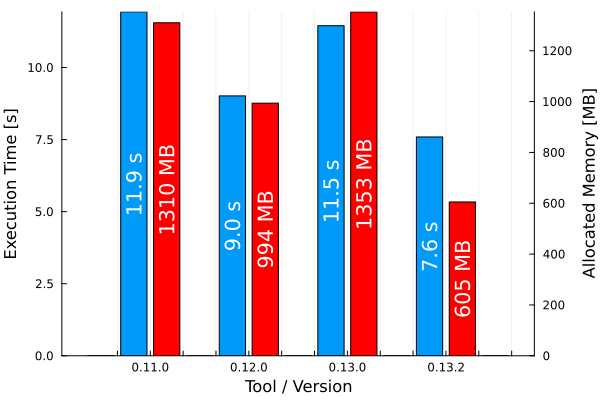

In [8]:
@everywhere workers solver=Tsit5()
@everywhere workers b=benchmarkSimulation(fmu, data, solver)
min_times, memories, allocs = runBenchmark()
resultPlot(versions, min_times, memories)

## Benchmark 1b: Implicit Solver (using Automatic Differentiation)

Model: VLDM (6 states, time- and state-events)

Mode: Model-Exchange

Solver: Rosenbrock23 (autodiff=true, tolerance=1e-4)

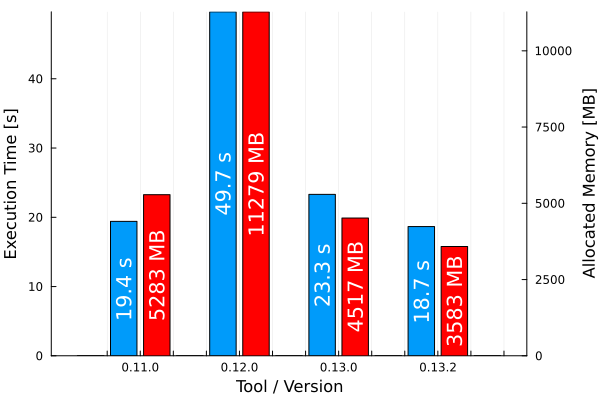

In [9]:
@everywhere workers solver=Rosenbrock23(autodiff=true)
@everywhere workers b=benchmarkSimulation(fmu, data, solver)
min_times, memories, allocs = runBenchmark()
resultPlot(versions, min_times, memories)

## Benchmark 2: Automatic Solver Determination

Model: VLDM (6 states, time- and state-events)

Mode: Model-Exchange

Solver: auto (by DifferentialEquations.jl)

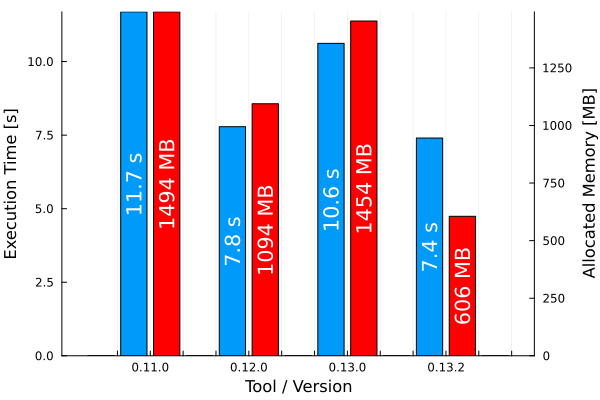

In [10]:
@everywhere workers solver=nothing
@everywhere workers b=benchmarkSimulation(fmu, data, solver)
min_times, memories, allocs = runBenchmark()
resultPlot(versions, min_times, memories)

## Benchmark 3: Non-Julia Solver

Model: VLDM (6 states, time- and state-events)

Mode: Model-Exchange

Solver: CVode (tolerance=1e-4)

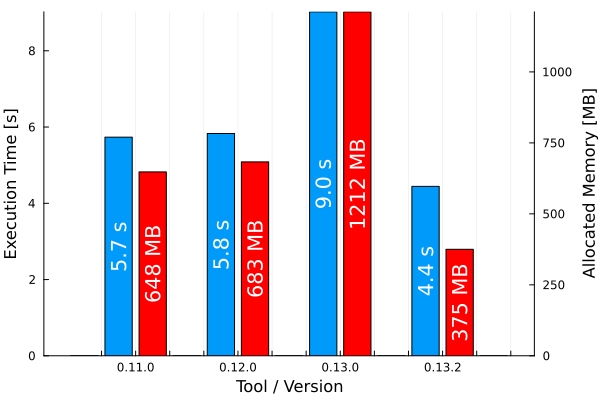

In [11]:
@everywhere workers solver = CVODE_BDF()
@everywhere workers b=benchmarkSimulation(fmu, data, solver)
min_times, memories, allocs = runBenchmark()
resultPlot(versions, min_times, memories)